Задание 1

Установим и импортируем необходимые библиотеки

In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\vav-2\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\vav-2\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [5]:
pip install matplotlib

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\vav-2\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [6]:
pip install scikit-learn

You should consider upgrading via the 'c:\Users\vav-2\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [7]:
pip install tensorflow

  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\vav-2\AppData\Local\Prog

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

Загружаем данные

https://www.kaggle.com/datasets/ehallmar/daily-historical-stock-prices-1970-2018

In [16]:
data = pd.read_csv("historical_stock_prices.csv")
data = data[data['ticker'] == 'AAPL']  # Выбираем данные по акциям Apple
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data['close'].resample('M').mean()  # Преобразуем данные в месячные значения

Выполняем нормализацию

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

Разделяем данные на обучающую и тестовую выборки

In [18]:
train_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

Выполним преобразование данных в последовательности

In [19]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

Преобразование в форму [samples, time steps, features]

In [20]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

LSTM

In [21]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=1)

Epoch 1/10
360/360 [==============================] - 1s 950us/step - loss: 0.0014
Epoch 2/10
360/360 [==============================] - 0s 922us/step - loss: 4.8931e-04
Epoch 3/10
360/360 [==============================] - 0s 900us/step - loss: 4.6173e-05
Epoch 4/10
360/360 [==============================] - 0s 906us/step - loss: 2.2172e-05
Epoch 5/10
360/360 [==============================] - 0s 900us/step - loss: 2.4555e-05
Epoch 6/10
360/360 [==============================] - 0s 883us/step - loss: 2.4479e-05
Epoch 7/10
360/360 [==============================] - 0s 846us/step - loss: 2.4180e-05
Epoch 8/10
360/360 [==============================] - 0s 846us/step - loss: 2.4242e-05
Epoch 9/10
360/360 [==============================] - 0s 849us/step - loss: 2.5634e-05
Epoch 10/10
360/360 [==============================] - 0s 874us/step - loss: 2.8635e-05


Прогнозирование

In [22]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

3/3 [==============================] - 0s 2ms/step


Преобразование обратно в исходный масштаб

In [23]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Расчёт RMSE

In [24]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print(f"Train Score: {trainScore:.2f} RMSE")
print(f"Test Score: {testScore:.2f} RMSE")

Train Score: 0.91 RMSE
Test Score: 9.54 RMSE


График ошибки на каждой эпохе

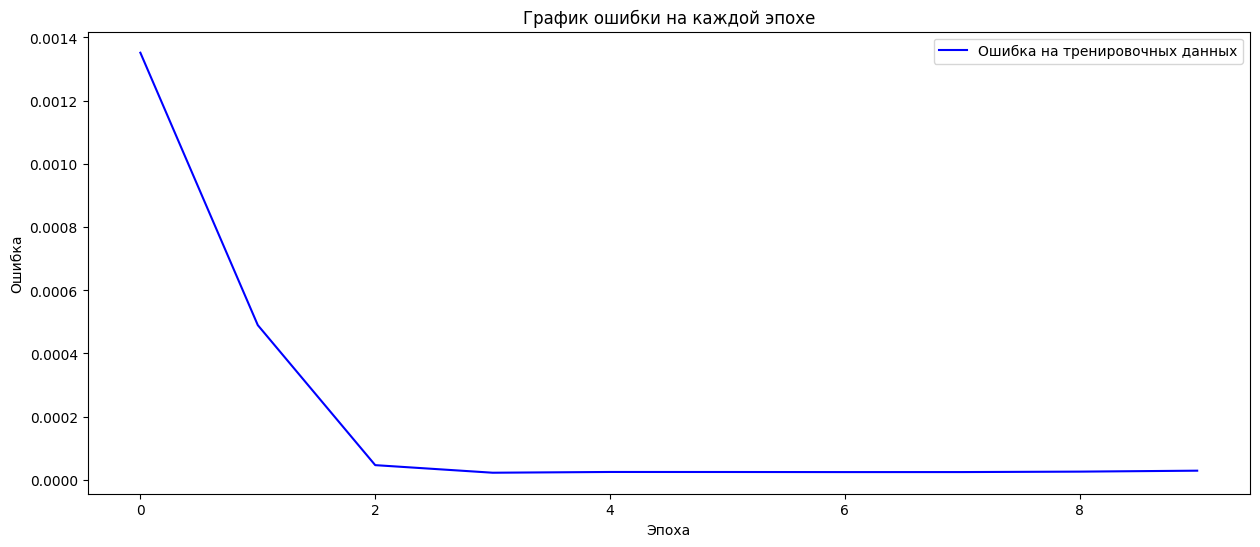

In [25]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], color='blue', label='Ошибка на тренировочных данных')
plt.title('График ошибки на каждой эпохе')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Визуализация

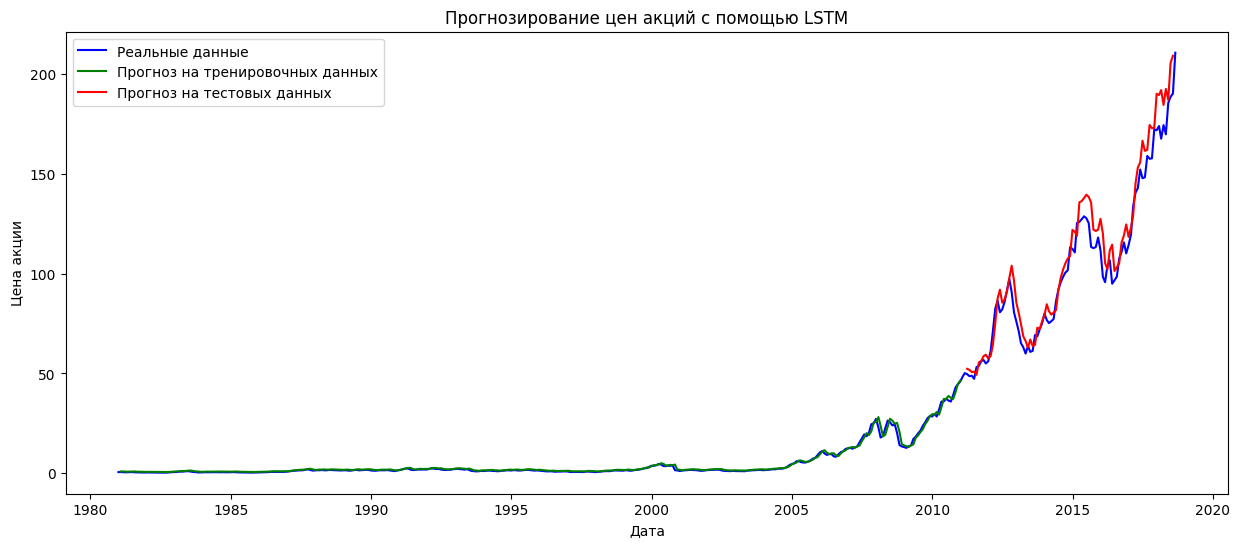

In [26]:
plt.figure(figsize=(15, 6))
plt.plot(data.index, data.values, color='blue', label='Реальные данные')
plt.plot(data.index[look_back:len(trainPredict)+look_back], trainPredict, color='green', label='Прогноз на тренировочных данных')
plt.plot(data.index[len(trainPredict)+(2*look_back)+1:len(data)-1], testPredict, color='red', label='Прогноз на тестовых данных')
plt.legend(loc='upper left')
plt.title('Прогнозирование цен акций с помощью LSTM')
plt.xlabel('Дата')
plt.ylabel('Цена акции')
plt.show()

Задание 2

Импортируем необходимые библиотеки

In [1]:
import pandas as pd

В целях экономии времени на прогонку, обрежу датасет до 1000 строчек

In [2]:
df = pd.read_csv("IMDB Movie Reviews.csv")
df = df.head(1000)
df.to_csv("IMDB Dataset short.csv", index=False)

In [4]:
pip install torch

     ---------------------------------------- 0.0/172.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/172.3 MB ? eta -:--:--
     ---------------------------------------- 0.1/172.3 MB 1.3 MB/s eta 0:02:12
     ---------------------------------------- 0.2/172.3 MB 1.3 MB/s eta 0:02:12
     ---------------------------------------- 0.2/172.3 MB 1.2 MB/s eta 0:02:19
     ---------------------------------------- 0.3/172.3 MB 1.1 MB/s eta 0:02:34
     ---------------------------------------- 0.3/172.3 MB 1.2 MB/s eta 0:02:20
     ---------------------------------------- 0.4/172.3 MB 1.3 MB/s eta 0:02:15
     ---------------------------------------- 0.5/172.3 MB 1.3 MB/s eta 0:02:12
     ---------------------------------------- 0.5/172.3 MB 1.3 MB/s eta 0:02:09
     ---------------------------------------- 0.6/172.3 MB 1.2 MB/s eta 0:02:24
     ---------------------------------------- 0.7/172.3 MB 1.3 MB/s eta 0:02:14
     ---------------------------------------- 0.8/172.

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.7.1 which is incompatible.


In [6]:
pip install transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/83/8d/f65f8138365462ace54458a9e164f4b28ce1141361970190eef36bdef986/transformers-4.32.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/118.5 kB ? eta -:--:--
     ---------- ----------------------------- 30.7/118.5 kB ? eta -:--:--
     ---------- ----------------------------- 30.7/118.5 kB ? eta -:--:--
     ---------------------- -------------- 71.7/118.5 kB 491.5 kB/s eta 0:00:01
     ------------------------------------ 118.5/118.5 kB 629.5 kB/s eta 0:00:00
  Obtaining dependency information for huggingface-hub<1.0,>=0.15.1 from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
  Obtaining dependency information for pyyaml>=5.1 from https://files.pythonhosted.org/packages/24/97/9b59b43431f98d01806b288532da38099cc6f2fea0f3d712e21e269c0279/PyYAML-6.0.1-cp31

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [8]:
pip install seaborn


     ---------------------------------------- 0.0/293.3 kB ? eta -:--:--
     ---------------------------------------- 0.0/293.3 kB ? eta -:--:--
     ---- ----------------------------------- 30.7/293.3 kB ? eta -:--:--
     ---- ----------------------------------- 30.7/293.3 kB ? eta -:--:--
     ------- ----------------------------- 61.4/293.3 kB 544.7 kB/s eta 0:00:01
     ----------- ------------------------- 92.2/293.3 kB 525.1 kB/s eta 0:00:01
     --------------- -------------------- 122.9/293.3 kB 602.4 kB/s eta 0:00:01
     --------------- -------------------- 122.9/293.3 kB 602.4 kB/s eta 0:00:01
     ------------------------------- ---- 256.0/293.3 kB 787.7 kB/s eta 0:00:01
     ------------------------------- ---- 256.0/293.3 kB 787.7 kB/s eta 0:00:01
     ------------------------------------ 293.3/293.3 kB 725.8 kB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import torch
import time
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

Подготовка данных

In [11]:
df = pd.read_csv("IMDB Dataset short.csv")
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'pos' else 0)
df['text'] = df['text'].str.replace('<br />', ' ')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 256

encodings = tokenizer.batch_encode_plus(df['text'].tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']
labels = torch.tensor(df['sentiment'].tolist())

train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks = train_test_split(input_ids, labels, attention_masks, test_size=0.2)

c:\Users\vav-2\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vav-2\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Загружаем и настраиваем модель BERT

In [13]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, output_attentions=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_inputs) * epochs)


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: f90b5d25-3b99-4847-9b20-87242d15d8e3)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\vav-2\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Обучение модели BERT

In [14]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)

def print_progress(epoch, loss):
    print(f'Эпоха: {epoch + 1}, Текущий loss: {loss.item()}')

train_losses = []  # добавлено для трекинга потерь при обучении
start_time = time.time()

for epoch in range(epochs):
    epoch_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

        if time.time() - start_time > 30:
            print_progress(epoch, loss)
            start_time = time.time()

    train_losses.append(epoch_loss / len(train_dataloader))

Эпоха: 1, Текущий loss: 0.6441636681556702
Эпоха: 1, Текущий loss: 0.6630285382270813
Эпоха: 1, Текущий loss: 0.6760566234588623
Эпоха: 1, Текущий loss: 0.6621923446655273
Эпоха: 1, Текущий loss: 0.6640558242797852
Эпоха: 1, Текущий loss: 0.5555925965309143
Эпоха: 1, Текущий loss: 0.49043601751327515
Эпоха: 1, Текущий loss: 0.4030427932739258
Эпоха: 1, Текущий loss: 0.4343760013580322
Эпоха: 1, Текущий loss: 0.5260816216468811
Эпоха: 2, Текущий loss: 0.3440991938114166
Эпоха: 2, Текущий loss: 0.21433936059474945
Эпоха: 2, Текущий loss: 0.3631219267845154
Эпоха: 2, Текущий loss: 0.1644727736711502
Эпоха: 2, Текущий loss: 0.37437704205513
Эпоха: 2, Текущий loss: 0.27408456802368164
Эпоха: 2, Текущий loss: 0.19939939677715302
Эпоха: 2, Текущий loss: 0.12687928974628448
Эпоха: 2, Текущий loss: 0.33481335639953613
Эпоха: 2, Текущий loss: 0.10223488509654999
Эпоха: 2, Текущий loss: 0.14918917417526245
Эпоха: 2, Текущий loss: 0.1876070350408554
Эпоха: 3, Текущий loss: 0.038338325917720795
Эпо

Оценка модели BERT

In [15]:
model.eval()
predictions, true_labels = [], []

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=16)

for batch in val_dataloader:
    with torch.no_grad():
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    predictions.extend(np.argmax(logits, axis=1))
    true_labels.extend(label_ids)

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
print(f"Точность: {precision:.4f}, Полнота: {recall:.4f}, F1-мера: {f1:.4f}")

Точность: 0.7870, Полнота: 0.9444, F1-мера: 0.8586


Визуализация

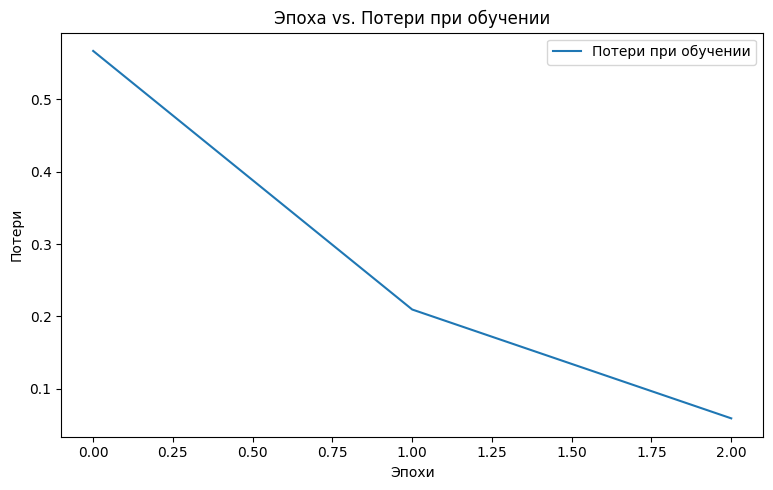

              precision    recall  f1-score   support

    negative       0.95      0.79      0.86       110
    positive       0.79      0.94      0.86        90

    accuracy                           0.86       200
   macro avg       0.87      0.87      0.86       200
weighted avg       0.87      0.86      0.86       200



In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Потери при обучении")
plt.title("Эпоха vs. Потери при обучении")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()

plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=["negative", "positive"]))

Визуализация внимания

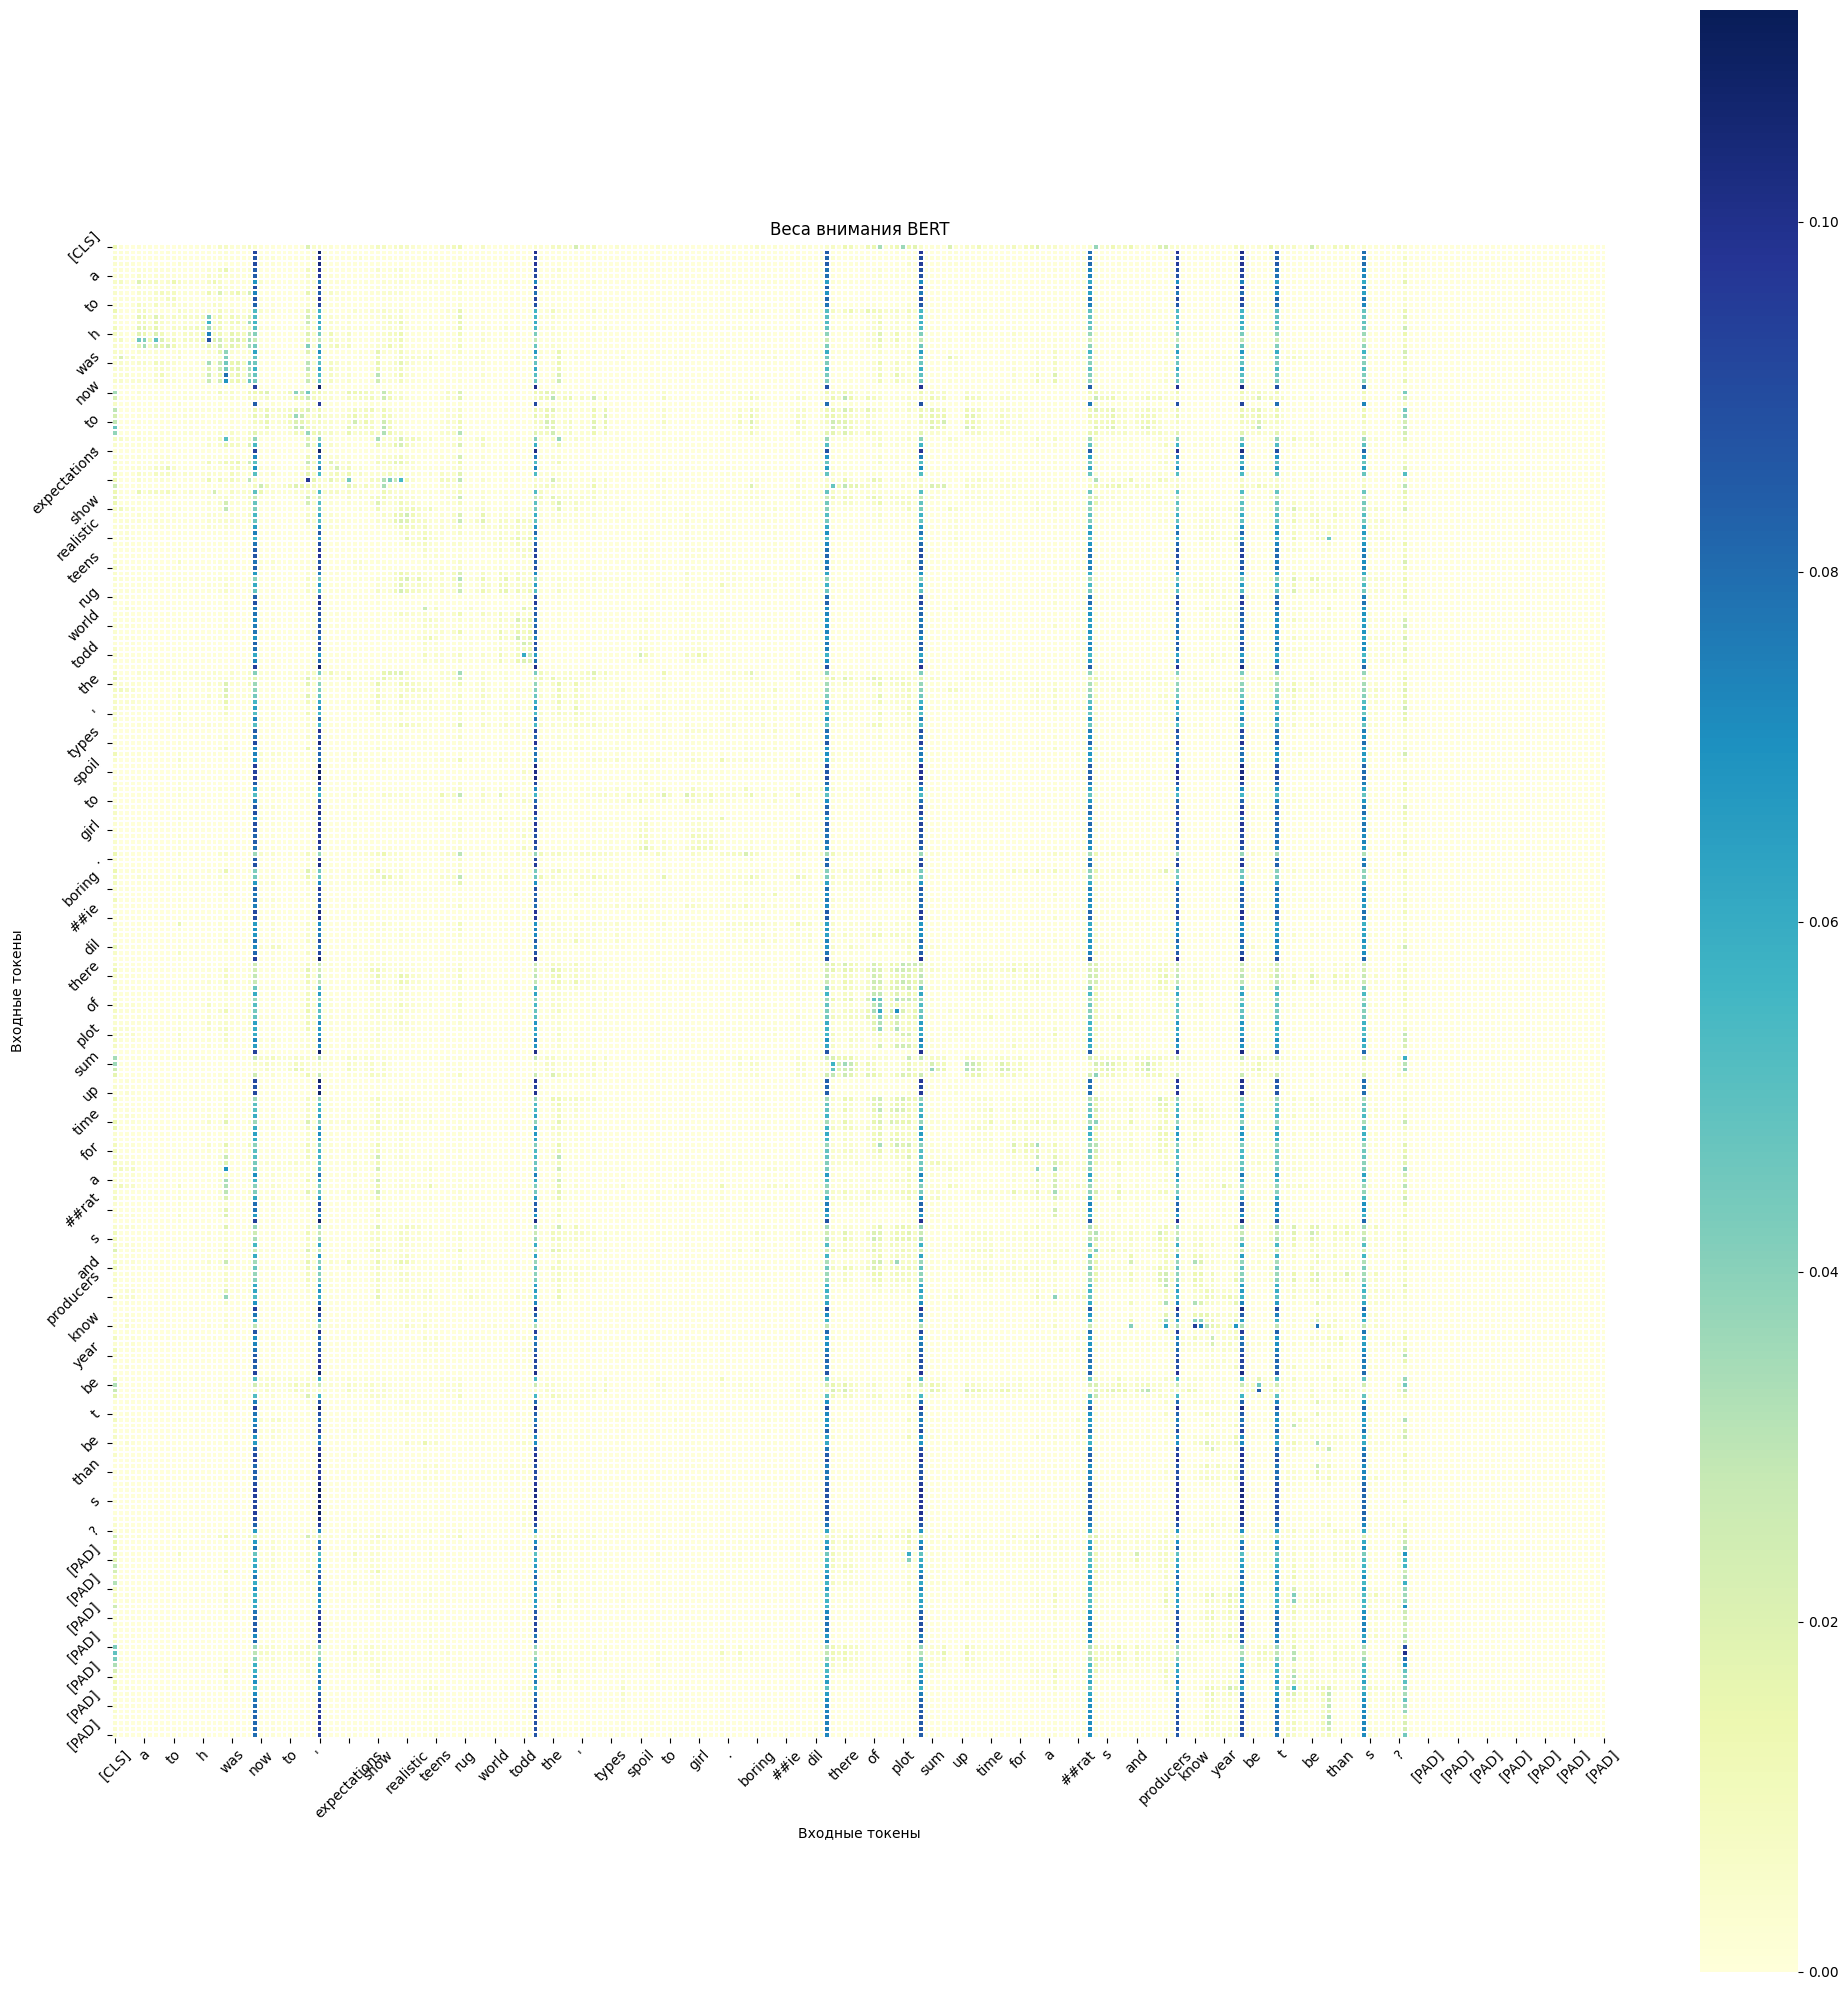

In [17]:
def plot_attention(attention, sentence, interval=5):
    fig, ax = plt.subplots(figsize=(20, 20))
    attention = attention[:len(sentence), :len(sentence)]
    sns.heatmap(attention, xticklabels=sentence, yticklabels=sentence, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)

  
    ax.set_xticks(ax.get_xticks()[::interval])
    ax.set_xticklabels(sentence[::interval], rotation=45, fontsize=10)

   
    ax.set_yticks(ax.get_yticks()[::interval])
    ax.set_yticklabels(sentence[::interval], rotation=45, fontsize=10)

    plt.xlabel('Входные токены')
    plt.ylabel('Входные токены')
    plt.title('Веса внимания BERT')
    plt.tight_layout()
    plt.show()


for batch in val_dataloader:
    input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
    break  

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    attentions = outputs.attentions


attention = attentions[-1][0][0].cpu().numpy()
sentence = tokenizer.convert_ids_to_tokens(input_ids[0])
plot_attention(attention, sentence)

Задание 3 

Используя Python библиотеку cv2, RetinaNET и вашу фотографию, содержащую любые объекты, решите задачу Object Detection (определение объектов на фотографии).

Устанавливаем необходимые библиотеки

In [2]:
pip install opencv-python-headless



  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/70/78/7a13730745684584db53e8aa3c3bd84beef2dcb32bebf627bda0d6df461e/opencv_python_headless-4.8.0.76-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.0 MB 245.8 kB/s eta 0:02:35
   ---------------------------------------- 0.1/38.0 MB 275.8 kB/s eta 0:02:18
   ---------------------------------------- 0.1/38.0 MB 275.8 kB/s eta 0:02:18
   ------------------------------

In [3]:
import cv2
print("OpenCV-Python Version {}".format(cv2.__version__))


OpenCV-Python Version 4.8.0


In [20]:
pip install tensorflow-hub

  Obtaining dependency information for tensorflow-hub from https://files.pythonhosted.org/packages/30/78/9d5292a2b616901bdb075bbf0c777b293f4140bb48108ac2b33fd716c2eb/tensorflow_hub-0.14.0-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/90.3 kB ? eta -:--:--
   ------------- -------------------------- 30.7/90.3 kB ? eta -:--:--
   --------------------------- ------------ 61.4/90.3 kB 825.8 kB/s eta 0:00:01
   ---------------------------------------- 90.3/90.3 kB 1.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [32]:
%matplotlib inline

path = 'img2.jpeg'
image_np = cv2.imread(path)

# BGR в RGB
image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

# Изображение в тензор
input_tensor = tf.image.convert_image_dtype(image_np, dtype=tf.uint8)
input_tensor = input_tensor[tf.newaxis, ...]

In [33]:
detector = hub.load("https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1")

In [34]:
detector_output = detector(input_tensor)

# Порог для фильтрации детекций
threshold = 0.3

Детекции на изображении

In [35]:
for i in range(int(detector_output["num_detections"])):
    score = detector_output["detection_scores"][0][i].numpy()
    if score > threshold:
        box = detector_output["detection_boxes"][0][i].numpy()
        y1, x1, y2, x2 = (box * [image_np.shape[0], image_np.shape[1], image_np.shape[0], image_np.shape[1]]).astype(int)
        cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"Class: {detector_output['detection_classes'][0][i].numpy()}, Score: {score:.2f}"
        cv2.putText(image_np, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

Результат

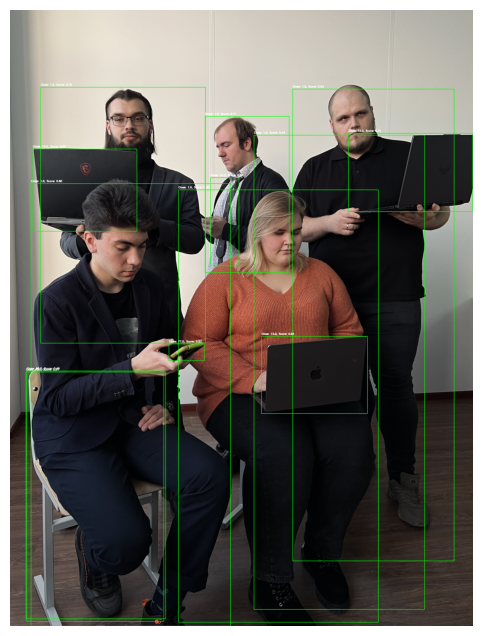

In [36]:
plt.figure(figsize=(12, 8))
plt.imshow(image_np)
plt.axis('off')
plt.show()